In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import sys
sys.path.insert(0, '..')
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 16
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')

import covid19

## data

In [3]:
data_italy_path = 'dpc-covid19-ita-andamento-nazionale.csv'
# data_italy_path = covid19.data.download('andamento-nazionale')

In [4]:
data_italy = pd.read_csv(data_italy_path, parse_dates=['data'], index_col=['data'])

data_italy.tail()

,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
data,,,,,,,,,,,
2020-03-06 18:00:00,ITA,2394,462,2856,1060,3916,620,523,197,4636,36359
2020-03-07 18:00:00,ITA,2651,567,3218,1843,5061,1145,589,233,5883,42062
2020-03-08 18:00:00,ITA,3557,650,4207,2180,6387,1326,622,366,7375,49937
2020-03-09 18:00:00,ITA,4316,733,5049,2936,7985,1598,724,463,9172,53826
2020-03-10 18:00:00,ITA,5038,877,5915,2599,8514,529,1004,631,10149,60761


## situation report

In [5]:
START_FIT = '2020-02-24'
STOP_FIT = None
EXTRAPOLTATE = ('2020-02-15T18:00', '2020-03-12T18:00')

In [6]:
fits = {}
fits['dimessi_guariti'] = covid19.fit.ExponentialFit.from_frame('dimessi_guariti', data_italy, start='2020-02-27', stop=STOP_FIT)
fits['ricoverati_con_sintomi_old'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start=START_FIT, stop='2020-03-06')
fits['ricoverati_con_sintomi'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-06', stop=STOP_FIT)
fits['terapia_intensiva_old'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start=START_FIT, stop='2020-03-07')
fits['terapia_intensiva'] = covid19.fit.ExponentialFit.from_frame('terapia_intensiva', data_italy, start='2020-03-07', stop=STOP_FIT)
fits['deceduti_old'] = covid19.fit.ExponentialFit.from_frame('deceduti', data_italy, start=START_FIT, stop=STOP_FIT)

# tentative fit
fits['deceduti'] = covid19.fit.ExponentialFit.from_frame('ricoverati_con_sintomi', data_italy, start='2020-03-06', stop=STOP_FIT).shift(4).scale(0.27)


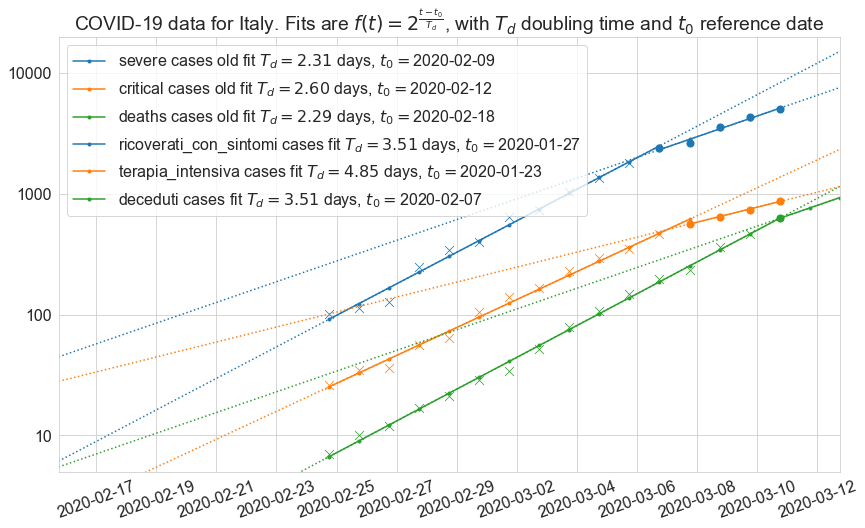

In [7]:
_, ax = plt.subplots(subplot_kw={'yscale': 'log', 'ylim': (5, 20000)})
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_old'], label='severe cases old', extrapolate=EXTRAPOLTATE, color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_old'], label='critical cases old', extrapolate=EXTRAPOLTATE, color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_old'], label='deaths cases old', extrapolate=EXTRAPOLTATE, color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind + ' cases', extrapolate=EXTRAPOLTATE, color=color)

_ = ax.set(title=r'COVID-19 data for Italy. Fits are $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')

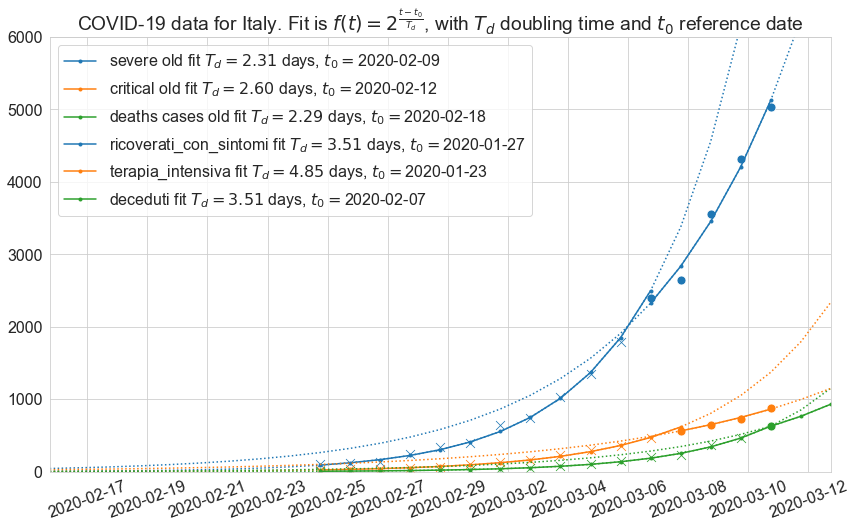

In [8]:
_, ax = plt.subplots(subplot_kw={'ylim': (0, 6000)})
covid19.plot.plot_fit(ax, fits['ricoverati_con_sintomi_old'], label='severe old', extrapolate=EXTRAPOLTATE, color=sns.color_palette()[0])
covid19.plot.plot_fit(ax, fits['terapia_intensiva_old'], label='critical old', extrapolate=EXTRAPOLTATE, color=sns.color_palette()[1])
covid19.plot.plot_fit(ax, fits['deceduti_old'], label='deaths cases old', extrapolate=EXTRAPOLTATE, color=sns.color_palette()[2])
for kind, color in zip(['ricoverati_con_sintomi', 'terapia_intensiva', 'deceduti'], sns.color_palette()):
    covid19.plot.plot(ax, data_italy[kind], fits[kind], label=kind, extrapolate=EXTRAPOLTATE, color=color)

_ = ax.set(title=r'COVID-19 data for Italy. Fit is $f(t) = 2 ^ \frac{t - t_0}{T_d}$, with $T_d$ doubling time and $t_0$ reference date')

## estimates

In [9]:
kinds = ['deceduti', 'deceduti_old', 'terapia_intensiva', 'ricoverati_con_sintomi', 'dimessi_guariti']
datetime_expected = '2020-03-11T18:00'
expected_values = []
for kind in kinds:
    expected_values.append(int(round(fits[kind].predict(datetime_expected))))
print(', '.join(f'{k}: {v}' for v, k in zip(expected_values, kinds)))

deceduti: 765, deceduti_old: 852, terapia_intensiva: 997, ricoverati_con_sintomi: 6246, dimessi_guariti: 1633
